In [75]:
import ast
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from matplotlib.patches import Rectangle
from scipy import ndimage as ndi
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"

## train dataframe

In [2]:
df = pd.read_csv("/app/_data/train.csv")
df.head()

id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [4]:
df["class"].unique()

array(['large_bowel', 'small_bowel', 'stomach'], dtype=object)

In [5]:
df.groupby("id")["class"].count().unique()

array([3])

#### For every slice ("id") there are 3 rows with classes 'large_bowel', 'small_bowel', 'stomach'.
It is more convenient to work with the data in wide format without duplicates

In [6]:
df = df.pivot(index="id", columns="class", values="segmentation").reset_index(
    drop=False
)
df["is_mask"] = df[["large_bowel", "small_bowel", "stomach"]].notna().any(1)
print(f"New dataframe shape: {df.shape[0]}")
df.head()

New dataframe shape: 38496


class                        id large_bowel small_bowel stomach  is_mask
0      case101_day20_slice_0001         NaN         NaN     NaN    False
1      case101_day20_slice_0002         NaN         NaN     NaN    False
2      case101_day20_slice_0003         NaN         NaN     NaN    False
3      case101_day20_slice_0004         NaN         NaN     NaN    False
4      case101_day20_slice_0005         NaN         NaN     NaN    False

## Metadata from images

In [7]:
paths = pd.DataFrame(
    glob.glob("/app/_data/train/*/*/scans/*.png"), columns=["img_path"]
)
paths.head()

img_path
0  /app/_data/train/case29/case29_day14/scans/sli...
1  /app/_data/train/case29/case29_day14/scans/sli...
2  /app/_data/train/case29/case29_day14/scans/sli...
3  /app/_data/train/case29/case29_day14/scans/sli...
4  /app/_data/train/case29/case29_day14/scans/sli...

In [8]:
paths.sample(3)["img_path"].values

array(['/app/_data/train/case54/case54_day32/scans/slice_0135_266_266_1.50_1.50.png',
       '/app/_data/train/case36/case36_day16/scans/slice_0126_266_266_1.50_1.50.png',
       '/app/_data/train/case32/case32_day18/scans/slice_0065_266_266_1.50_1.50.png'],
      dtype=object)

"The image filenames include 4 numbers (ex. 276_276_1.63_1.63.png). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel."

In [9]:
paths["img_name"] = (
    paths["img_path"].str.split("/").str[-1].str.replace(".png", "", regex=True)
)
paths["y_spacing"] = paths["img_name"].str.split("_").str[-2]
paths["x_spacing"] = paths["img_name"].str.split("_").str[-1]
paths["img_height"] = paths["img_name"].str.split("_").str[2].astype("int")
paths["img_width"] = paths["img_name"].str.split("_").str[3].astype("int")
paths["case"] = paths["img_path"].str.split("/").str[4]
paths["day"] = paths["img_path"].str.split("/").str[5].str.split("_").str[-1]
paths["slice"] = paths["img_name"].str.split("_").str[:2].str.join("_")
paths["id"] = paths["case"] + "_" + paths["day"] + "_" + paths["slice"]
paths["day"] = paths["day"].str.replace("day", "", regex=True).astype("int")
paths["slice"] = paths["slice"].str.replace("slice_", "", regex=True).astype("int")

In [10]:
paths.head()

img_path  \
0  /app/_data/train/case29/case29_day14/scans/sli...   
1  /app/_data/train/case29/case29_day14/scans/sli...   
2  /app/_data/train/case29/case29_day14/scans/sli...   
3  /app/_data/train/case29/case29_day14/scans/sli...   
4  /app/_data/train/case29/case29_day14/scans/sli...   

                       img_name y_spacing x_spacing  img_height  img_width  \
0  slice_0044_266_266_1.50_1.50      1.50      1.50         266        266   
1  slice_0095_266_266_1.50_1.50      1.50      1.50         266        266   
2  slice_0119_266_266_1.50_1.50      1.50      1.50         266        266   
3  slice_0115_266_266_1.50_1.50      1.50      1.50         266        266   
4  slice_0019_266_266_1.50_1.50      1.50      1.50         266        266   

     case  day  slice                       id  
0  case29   14     44  case29_day14_slice_0044  
1  case29   14     95  case29_day14_slice_0095  
2  case29   14    119  case29_day14_slice_0119  
3  case29   14    115  case29_day14_slice_0115  
4  case29   14     19  case29_day14_slice_0019

### Real image height/width, mean image value

In [11]:
def get_img_info(df, ix):
    img_path = df.loc[ix, "img_path"]
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    shape = img.shape[:2]
    max_pixel_value = np.max(img)
    min_pixel_value = np.min(img)
    abs_mean_pixel_value = np.mean(img)
    img = img.astype("float32")
    img -= np.min(img)
    img /= np.max(img)
    rel_mean_pixel_value = np.mean(img)
    return (
        shape,
        max_pixel_value,
        min_pixel_value,
        abs_mean_pixel_value,
        rel_mean_pixel_value,
    )

In [12]:
for ix in tqdm(paths.index):
    (
        (height, width),
        max_pixel_value,
        min_pixel_value,
        abs_mean_pixel_value,
        rel_mean_pixel_value,
    ) = get_img_info(paths, ix)
    paths.loc[ix, "real_height"] = height
    paths.loc[ix, "real_width"] = width
    paths.loc[ix, "h_w_ratio"] = height / width
    paths.loc[ix, "max_pixel_value"] = max_pixel_value
    paths.loc[ix, "min_pixel_value"] = min_pixel_value
    paths.loc[ix, "abs_mean_pixel_value"] = abs_mean_pixel_value
    paths.loc[ix, "rel_mean_pixel_value"] = rel_mean_pixel_value

100% 38496/38496 [02:35<00:00, 248.36it/s]


In [13]:
df = df.merge(paths, on=["id"], how="left")
df.head()

id large_bowel small_bowel stomach  is_mask  \
0  case101_day20_slice_0001         NaN         NaN     NaN    False   
1  case101_day20_slice_0002         NaN         NaN     NaN    False   
2  case101_day20_slice_0003         NaN         NaN     NaN    False   
3  case101_day20_slice_0004         NaN         NaN     NaN    False   
4  case101_day20_slice_0005         NaN         NaN     NaN    False   

                                            img_path  \
0  /app/_data/train/case101/case101_day20/scans/s...   
1  /app/_data/train/case101/case101_day20/scans/s...   
2  /app/_data/train/case101/case101_day20/scans/s...   
3  /app/_data/train/case101/case101_day20/scans/s...   
4  /app/_data/train/case101/case101_day20/scans/s...   

                       img_name y_spacing x_spacing  img_height  ...     case  \
0  slice_0001_266_266_1.50_1.50      1.50      1.50         266  ...  case101   
1  slice_0002_266_266_1.50_1.50      1.50      1.50         266  ...  case101   
2  slice_0003_266_266_1.50_1.50      1.50      1.50         266  ...  case101   
3  slice_0004_266_266_1.50_1.50      1.50      1.50         266  ...  case101   
4  slice_0005_266_266_1.50_1.50      1.50      1.50         266  ...  case101   

  day  slice  real_height  real_width  h_w_ratio  max_pixel_value  \
0  20      1        266.0       266.0        1.0            125.0   
1  20      2        266.0       266.0        1.0            115.0   
2  20      3        266.0       266.0        1.0            117.0   
3  20      4        266.0       266.0        1.0            124.0   
4  20      5        266.0       266.0        1.0            140.0   

   min_pixel_value  abs_mean_pixel_value  rel_mean_pixel_value  
0              0.0              7.387246              0.059098  
1              0.0              8.038258              0.069898  
2              0.0              8.799508              0.075209  
3              0.0              9.531616              0.076868  
4              0.0             10.397012              0.074264  

[5 rows x 21 columns]

# Data analysis

In [14]:
df.describe()

img_height     img_width           day         slice   real_height  \
count  38496.000000  38496.000000  38496.000000  38496.000000  38496.000000   
mean     293.618454    279.029925     13.354946     71.502494    279.029925   
std       42.688415     20.051109     10.397455     41.492726     20.051109   
min      234.000000    234.000000      0.000000      1.000000    234.000000   
25%      266.000000    266.000000      0.000000     36.000000    266.000000   
50%      266.000000    266.000000     16.000000     71.000000    266.000000   
75%      360.000000    310.000000     21.000000    107.000000    310.000000   
max      360.000000    310.000000     39.000000    144.000000    310.000000   

         real_width     h_w_ratio  max_pixel_value  min_pixel_value  \
count  38496.000000  38496.000000     38496.000000          38496.0   
mean     293.618454      0.959476      5882.677369              0.0   
std       42.688415      0.063137      5116.371094              0.0   
min      234.000000      0.861111        19.000000              0.0   
25%      266.000000      0.861111       603.000000              0.0   
50%      266.000000      1.000000      5724.000000              0.0   
75%      360.000000      1.000000     10620.000000              0.0   
max      360.000000      1.000000     15865.000000              0.0   

       abs_mean_pixel_value  rel_mean_pixel_value  
count          38496.000000          38496.000000  
mean             756.810807              0.113794  
std              788.676465              0.047901  
min                1.555735              0.005592  
25%               57.869121              0.077228  
50%              483.619252              0.108853  
75%             1354.015377              0.145722  
max             3536.714342              0.299011

In [15]:
df[df["is_mask"]].describe()

img_height     img_width          day         slice   real_height  \
count  16590.000000  16590.000000  16590.00000  16590.000000  16590.000000   
mean     293.867511    279.217119     13.07173     82.440687    279.217119   
std       42.665129     20.009486     10.30272     22.098025     20.009486   
min      234.000000    234.000000      0.00000      2.000000    234.000000   
25%      266.000000    266.000000      0.00000     66.000000    266.000000   
50%      266.000000    266.000000     15.00000     84.000000    266.000000   
75%      360.000000    310.000000     21.00000    100.000000    310.000000   
max      360.000000    310.000000     39.00000    137.000000    310.000000   

         real_width     h_w_ratio  max_pixel_value  min_pixel_value  \
count  16590.000000  16590.000000     16590.000000          16590.0   
mean     293.867511      0.959304      7199.655817              0.0   
std       42.665129      0.063216      5668.489571              0.0   
min      234.000000      0.861111       273.000000              0.0   
25%      266.000000      0.861111       734.000000              0.0   
50%      266.000000      1.000000      9217.500000              0.0   
75%      360.000000      1.000000     12375.750000              0.0   
max      360.000000      1.000000     15865.000000              0.0   

       abs_mean_pixel_value  rel_mean_pixel_value  
count          16590.000000          16590.000000  
mean            1073.138288              0.136329  
std              937.335018              0.048280  
min               29.663584              0.015036  
25%               73.975137              0.103060  
50%             1206.682557              0.136751  
75%             1869.081138              0.170404  
max             3536.714342              0.299011

Thera are 3 classes: 'large_bowel', 'small_bowel' and 'stomach'

## Case-day-slice statistics

In [16]:
cases = df["case"].unique().tolist()
stat_df = pd.DataFrame(
    columns=[
        "case",
        "day",
        "days_monotonic",
        "period",
        "slices_monotonic",
        "num_slices",
    ]
)
for case in cases:
    case_df = (
        df.query("case == @case")
        .sort_values(["day", "slice"])[["case", "day", "slice"]]
        .reset_index(drop=True)
    )
    days = case_df["day"].unique()
    days_monotonic = all([(days[i + 1] - days[i]) == 1 for i in range(len(days) - 1)])
    period = days.shape[0]
    for day in days:
        day_df = case_df.query("day == @day").reset_index(drop=True)
        slices = day_df["slice"].unique()
        slices_monotonic = all(
            [(slices[i + 1] - slices[i]) == 1 for i in range(len(slices) - 1)]
        )
        num_slices = day_df.shape[0]
        stat_df = stat_df.append(
            {
                "case": case,
                "day": day,
                "days_monotonic": days_monotonic,
                "period": period,
                "slices_monotonic": slices_monotonic,
                "num_slices": num_slices,
            },
            ignore_index=True,
        )

In [17]:
stat_df.head()

case day days_monotonic period slices_monotonic num_slices
0  case101  20          False      4             True        144
1  case101  22          False      4             True        144
2  case101  26          False      4             True        144
3  case101  32          False      4             True        144
4  case102   0           True      1             True        144

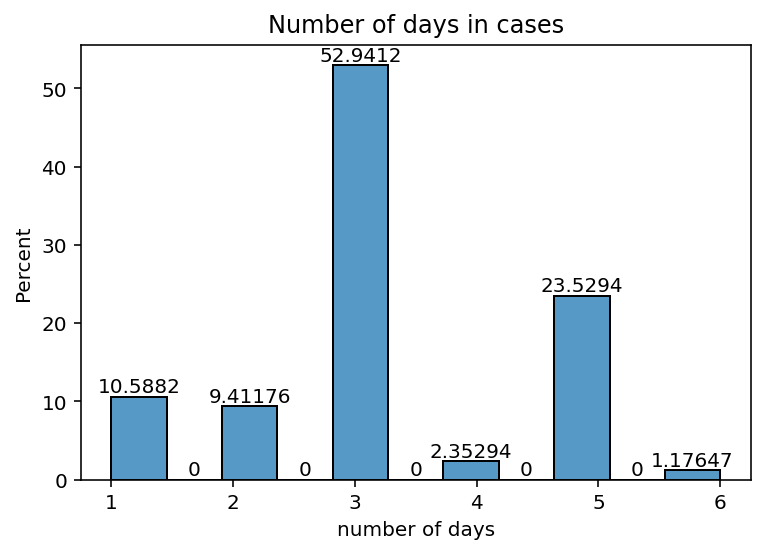

In [18]:
plt.title("Number of days in cases")

fig = sns.histplot(stat_df.drop_duplicates("case")["period"], stat="percent")
fig.bar_label(fig.containers[0])
fig.set(xlabel="number of days")
plt.show();

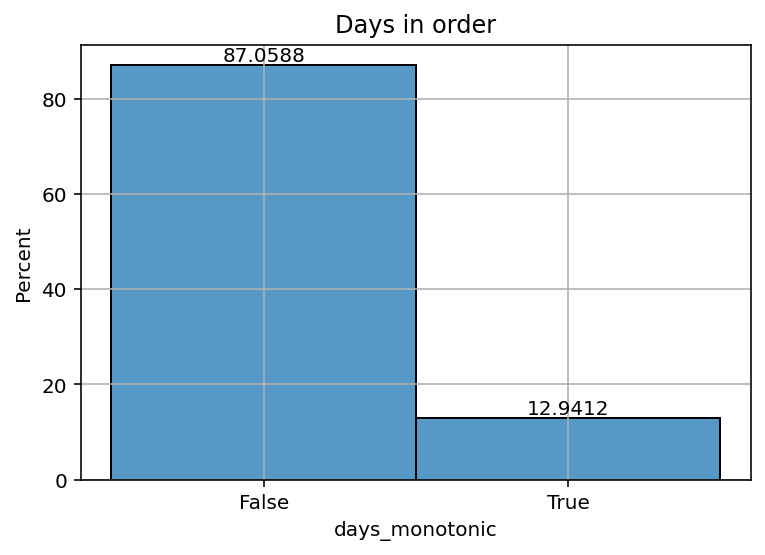

In [19]:
plt.title("Days in order")
plt.grid()
fig = sns.histplot(
    stat_df.drop_duplicates("case")["days_monotonic"].astype("str"), stat="percent"
)
fig.bar_label(fig.containers[0])
plt.show();

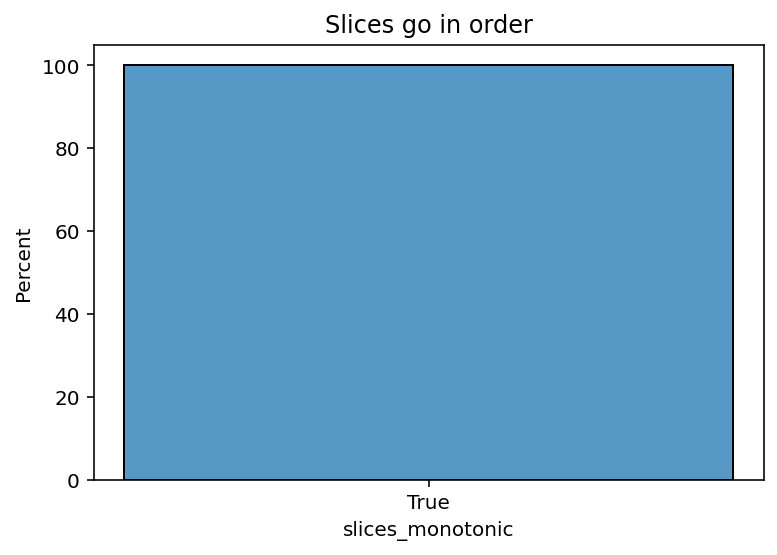

In [20]:
fig = sns.histplot(
    stat_df.drop_duplicates("case")["slices_monotonic"].astype("str"), stat="percent"
)
fig.set(title="Slices go in order")
plt.show();

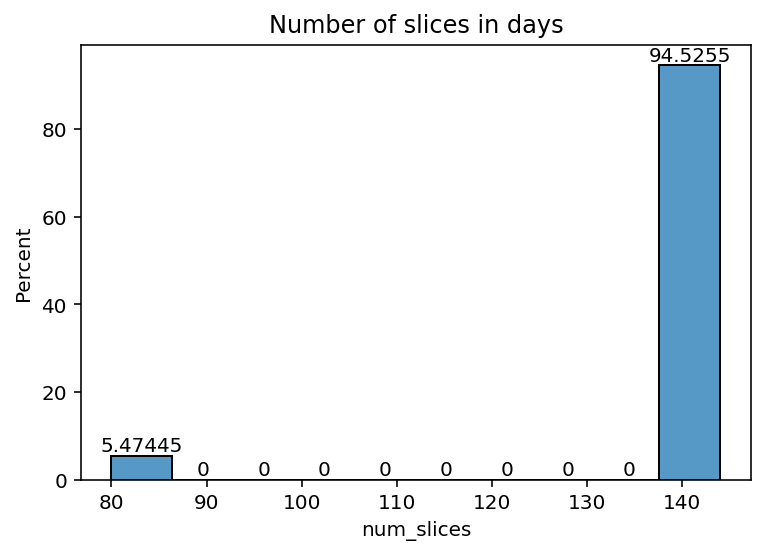

In [21]:
fig = sns.histplot(stat_df["num_slices"], stat="percent")
fig.set(title="Number of slices in days")
fig.bar_label(fig.containers[0])
plt.show();

 - All slices go in order, there are no missing slices in the middle,
 - 87% of cases have days random mixed, not in order,
 - 53% of cases have slices for 3 days, 23% - for 5 days,
 - 94.5% of cases have 144 slices per day, 5.5% - 80 slices.

## Mask analysis

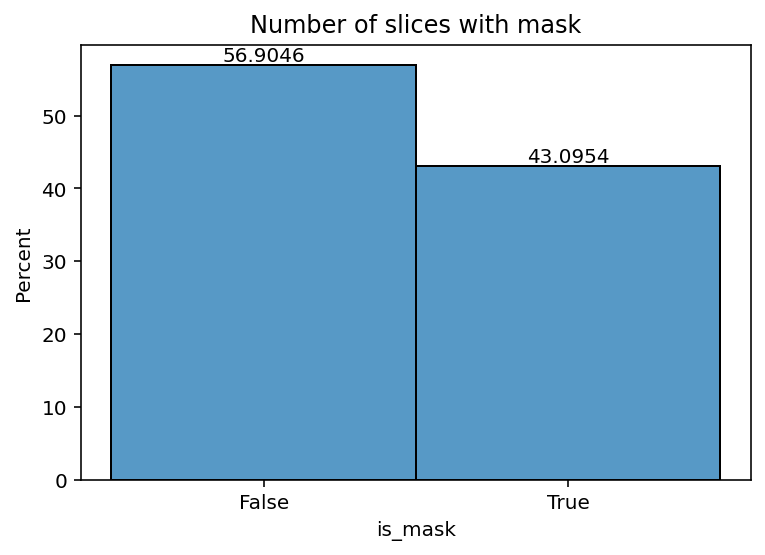

In [22]:
fig = sns.histplot(df["is_mask"].astype("str"), stat="percent")
fig.set(title="Number of slices with mask")
fig.bar_label(fig.containers[0])
plt.show();

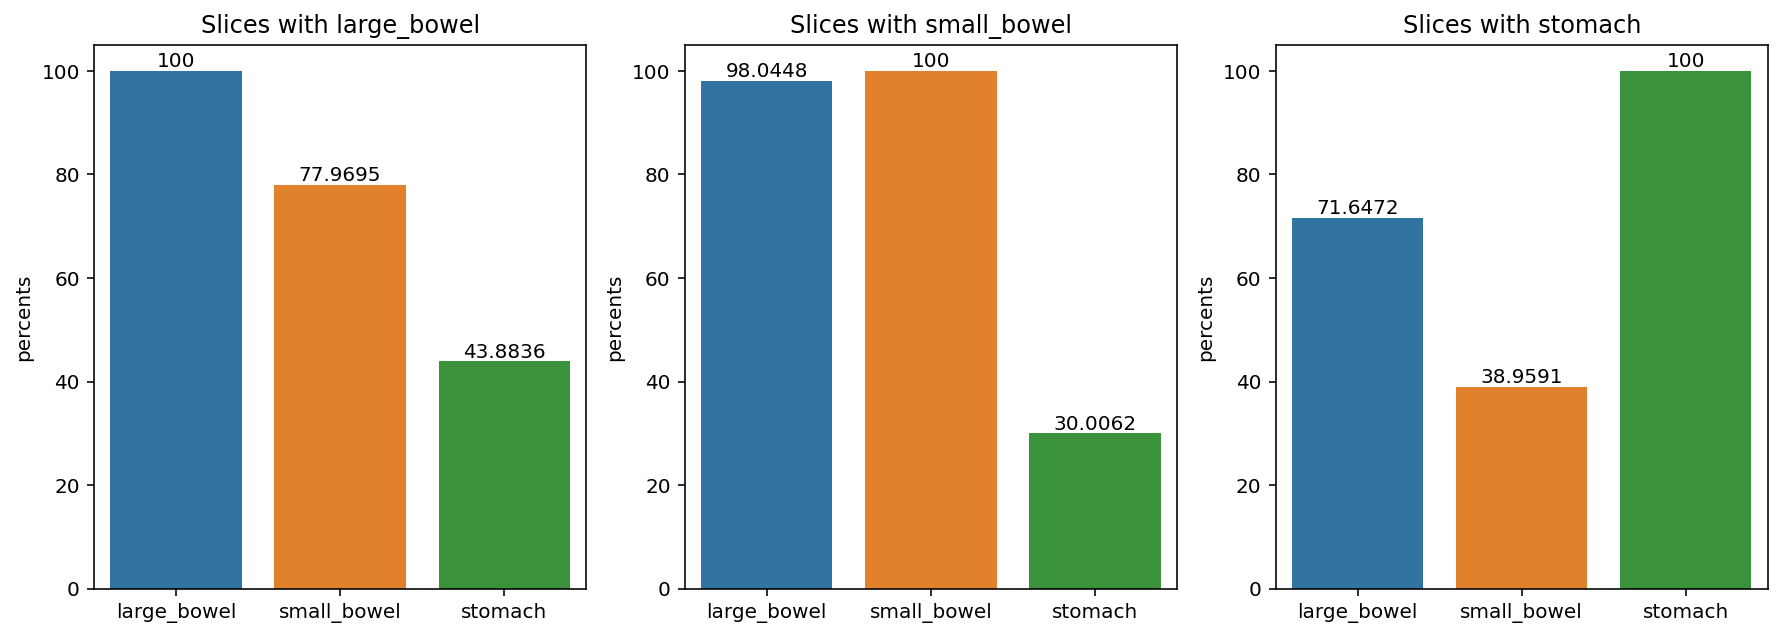

In [23]:
labels = ["large_bowel", "small_bowel", "stomach"]
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    fig = sns.barplot(
        data=pd.DataFrame(
            [
                df[df[labels[i]].notna()][labels].count()
                * 100
                / df[df[labels[i]].notna()].shape[0]
            ],
        )
    )
    fig.set(title=f"Slices with {labels[i]}", ylabel="percents")
    fig.bar_label(fig.containers[0])
plt.show();

In [24]:
df[
    (df["large_bowel"].notna()) & (df["small_bowel"].notna()) & (df["stomach"].notna())
].shape[0] / df.shape[0]

0.08315149625935161

 - 43.1% of slices have mask;
 - 8.3% of slices have all classes,
 - in 77% slices with large_bowel there are also small_bowel and in 43% - stomach,
 - in 98% slices with small_bowel there are also large_bowel and in 30% - stomach,
 - in 71.6% slices with stomach there are also large_bowel and in 38.9% - small_bowel.

## Image resolution analysis

In [25]:
df[df["real_height"] != df["img_height"]][["real_height", "img_height"]].shape[0]
df[df["real_width"] != df["img_width"]][["real_width", "img_width", "img_path"]].shape[
    0
]

11232

11232

In [26]:
df[df["real_width"] != df["img_width"]][
    ["real_height", "real_width", "img_height", "img_width", "img_path"]
].values[0].tolist()

[310.0,
 360.0,
 360,
 310,
 '/app/_data/train/case102/case102_day0/scans/slice_0001_360_310_1.50_1.50.png']

#### It seems, that "slice height / width" in image name are  slice width / height 

In [27]:
df[["real_height", "real_width"]].describe()

real_height    real_width
count  38496.000000  38496.000000
mean     279.029925    293.618454
std       20.051109     42.688415
min      234.000000    234.000000
25%      266.000000    266.000000
50%      266.000000    266.000000
75%      310.000000    360.000000
max      310.000000    360.000000

In [28]:
print(
    "Percent of square slices:",
    df[df["real_height"] == df["real_width"]].shape[0] * 100 / df.shape[0],
)

Percent of square slices: 70.82294264339153


In [31]:
df[["real_height", "real_width"]].value_counts() * 100 / df.shape[0]

real_height  real_width
266.0        266.0         67.331671
310.0        360.0         29.177057
276.0        276.0          3.117207
234.0        234.0          0.374065
dtype: float64

In [33]:
df[["y_spacing", "x_spacing"]].value_counts() * 100 / df.shape[0]

y_spacing  x_spacing
1.50       1.50         96.882793
1.63       1.63          3.117207
dtype: float64

In [47]:
# check if all slices during the day have the same resolution
for (case, day), group_df in df.groupby(["case", "day"]):
    if (
        group_df["real_height"].unique().shape[0] != 1
        or group_df["real_width"].unique().shape[0] != 1
    ):
        print(case, day)

In [14]:
df.to_csv("/app/_data/full_train.csv", index=False)

 - 70.8 % of slices are square,
 - non-square slices have resolution 310\*360 pixels,
 - 67.3% of slices have resolution 266\*266,
 - 3.1% of slices have resolution 276\*276,
 - 0.37% of slices have resolution 234\*234,
 - heigh/width pixel spacing are always equal,
 - 96.88% of slices have 1.5mm heigh/width pixel spacing,
 - 3.12% of slices have 1.63mm heigh/width pixel spacing,
 - slices during one day have the same resolution.

## Pixel values

In [56]:
df[
    [
        "min_pixel_value",
        "max_pixel_value",
        "abs_mean_pixel_value",
        "rel_mean_pixel_value",
    ]
].describe()

min_pixel_value  max_pixel_value  abs_mean_pixel_value  \
count          38496.0     38496.000000          38496.000000   
mean               0.0      5882.677369            756.810807   
std                0.0      5116.371094            788.676465   
min                0.0        19.000000              1.555735   
25%                0.0       603.000000             57.869121   
50%                0.0      5724.000000            483.619252   
75%                0.0     10620.000000           1354.015377   
max                0.0     15865.000000           3536.714342   

       rel_mean_pixel_value  
count          38496.000000  
mean               0.113794  
std                0.047901  
min                0.005592  
25%                0.077228  
50%                0.108853  
75%                0.145722  
max                0.299011

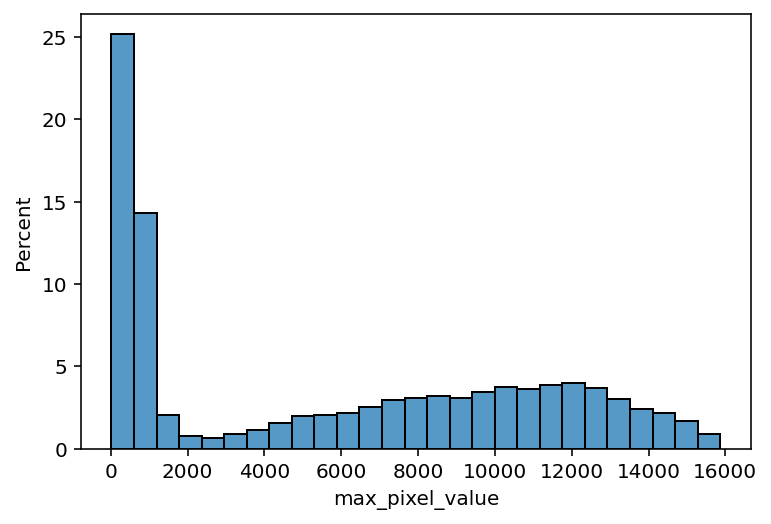

In [65]:
sns.histplot(df["max_pixel_value"], stat="percent")
fig.set(title="Absolute max pixel value")
plt.show();

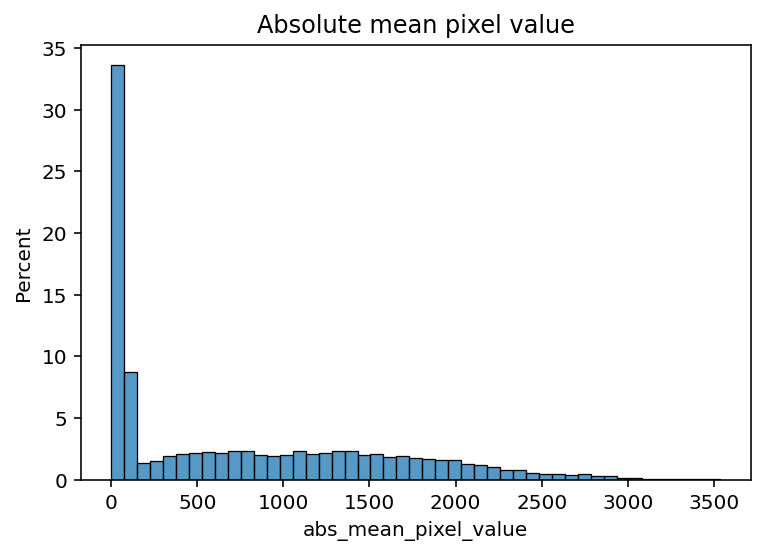

In [51]:
fig = sns.histplot(df["abs_mean_pixel_value"], stat="percent")
fig.set(title="Absolute mean pixel value")
plt.show();

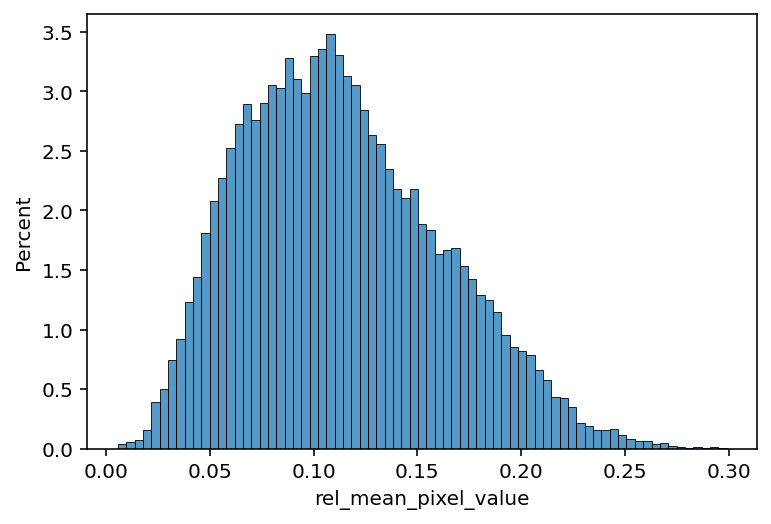

In [54]:
sns.histplot(df["rel_mean_pixel_value"], stat="percent")
fig.set(title="Normalized mean pixel value")
plt.show();

 - all slices have min pixel value 0,
 - 25% of slices have max pixel value less than 600 and absolute mean pixel value less than 57.8,
 - despite this, the distribution of normalized mean pixel value is close to normal.

## Images

In [66]:
def rle_decode(mask_array, img_shape):
    h, w = img_shape
    img_mask = np.zeros(h * w)
    rle_mask = np.array(mask_array.split(), dtype="int")
    starts = rle_mask[0::2] - 1
    ends = rle_mask[1::2] + starts
    for start, end in zip(starts, ends):
        img_mask[start:end] = 1
    return img_mask.reshape([h, w])

In [68]:
def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype("float32")
    img -= np.min(img)
    img /= np.max(img)
    return img

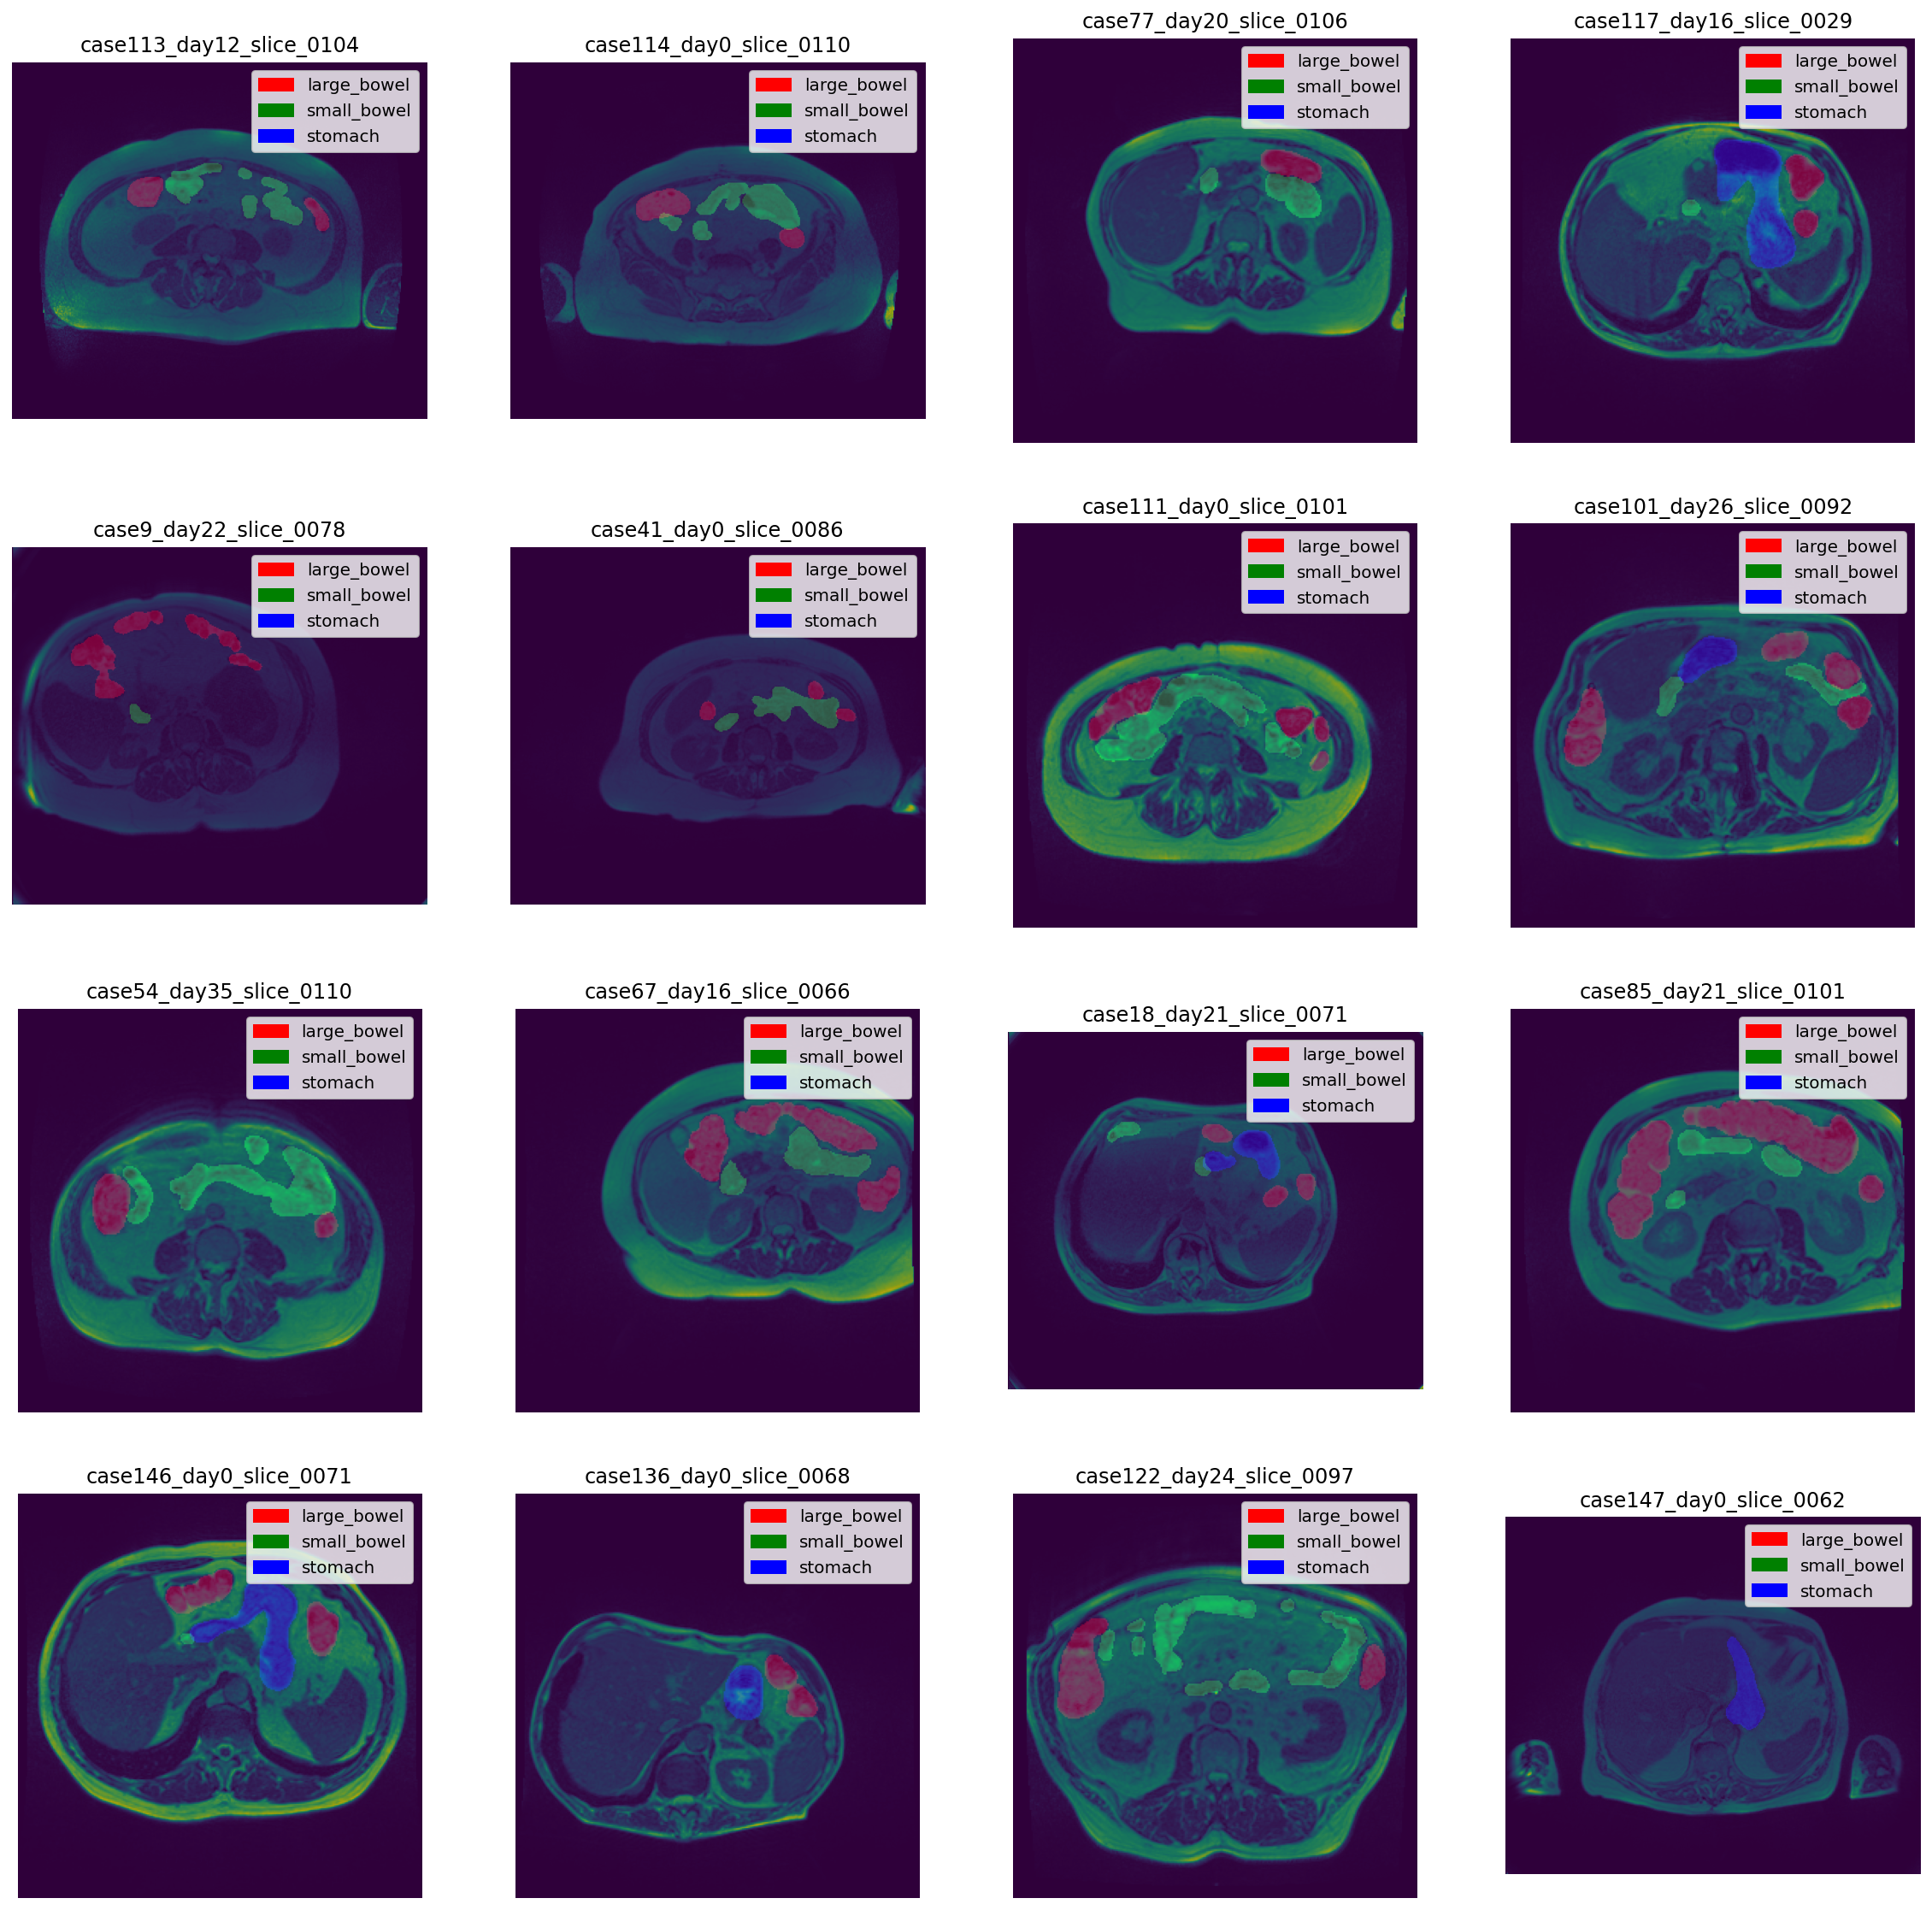

In [82]:
plt.figure(figsize=(20, 20))
for i in range(16):
    colors = ["red", "green", "blue"]
    ix = df[df["is_mask"]].index[np.random.randint(df[df["is_mask"]].index.shape[0])]
    img = read_img(
        img_path=df.loc[ix, "img_path"],
    )
    mask = np.zeros([img.shape[0], img.shape[1], 3])
    for c in range(3):
        rle = df.loc[ix, labels[c]]
        if rle == rle:
            mask[:, :, c] = rle_decode(rle, img.shape[:2])
    plt.subplot(4, 4, i + 1)
    plt.title(df.loc[ix, "id"])
    plt.imshow(img)
    plt.imshow(mask, alpha=0.3)
    handles = [Rectangle((0, 0), 1, 1, color=c) for c in colors]
    plt.legend(handles, labels)
    plt.axis("off")
plt.show();

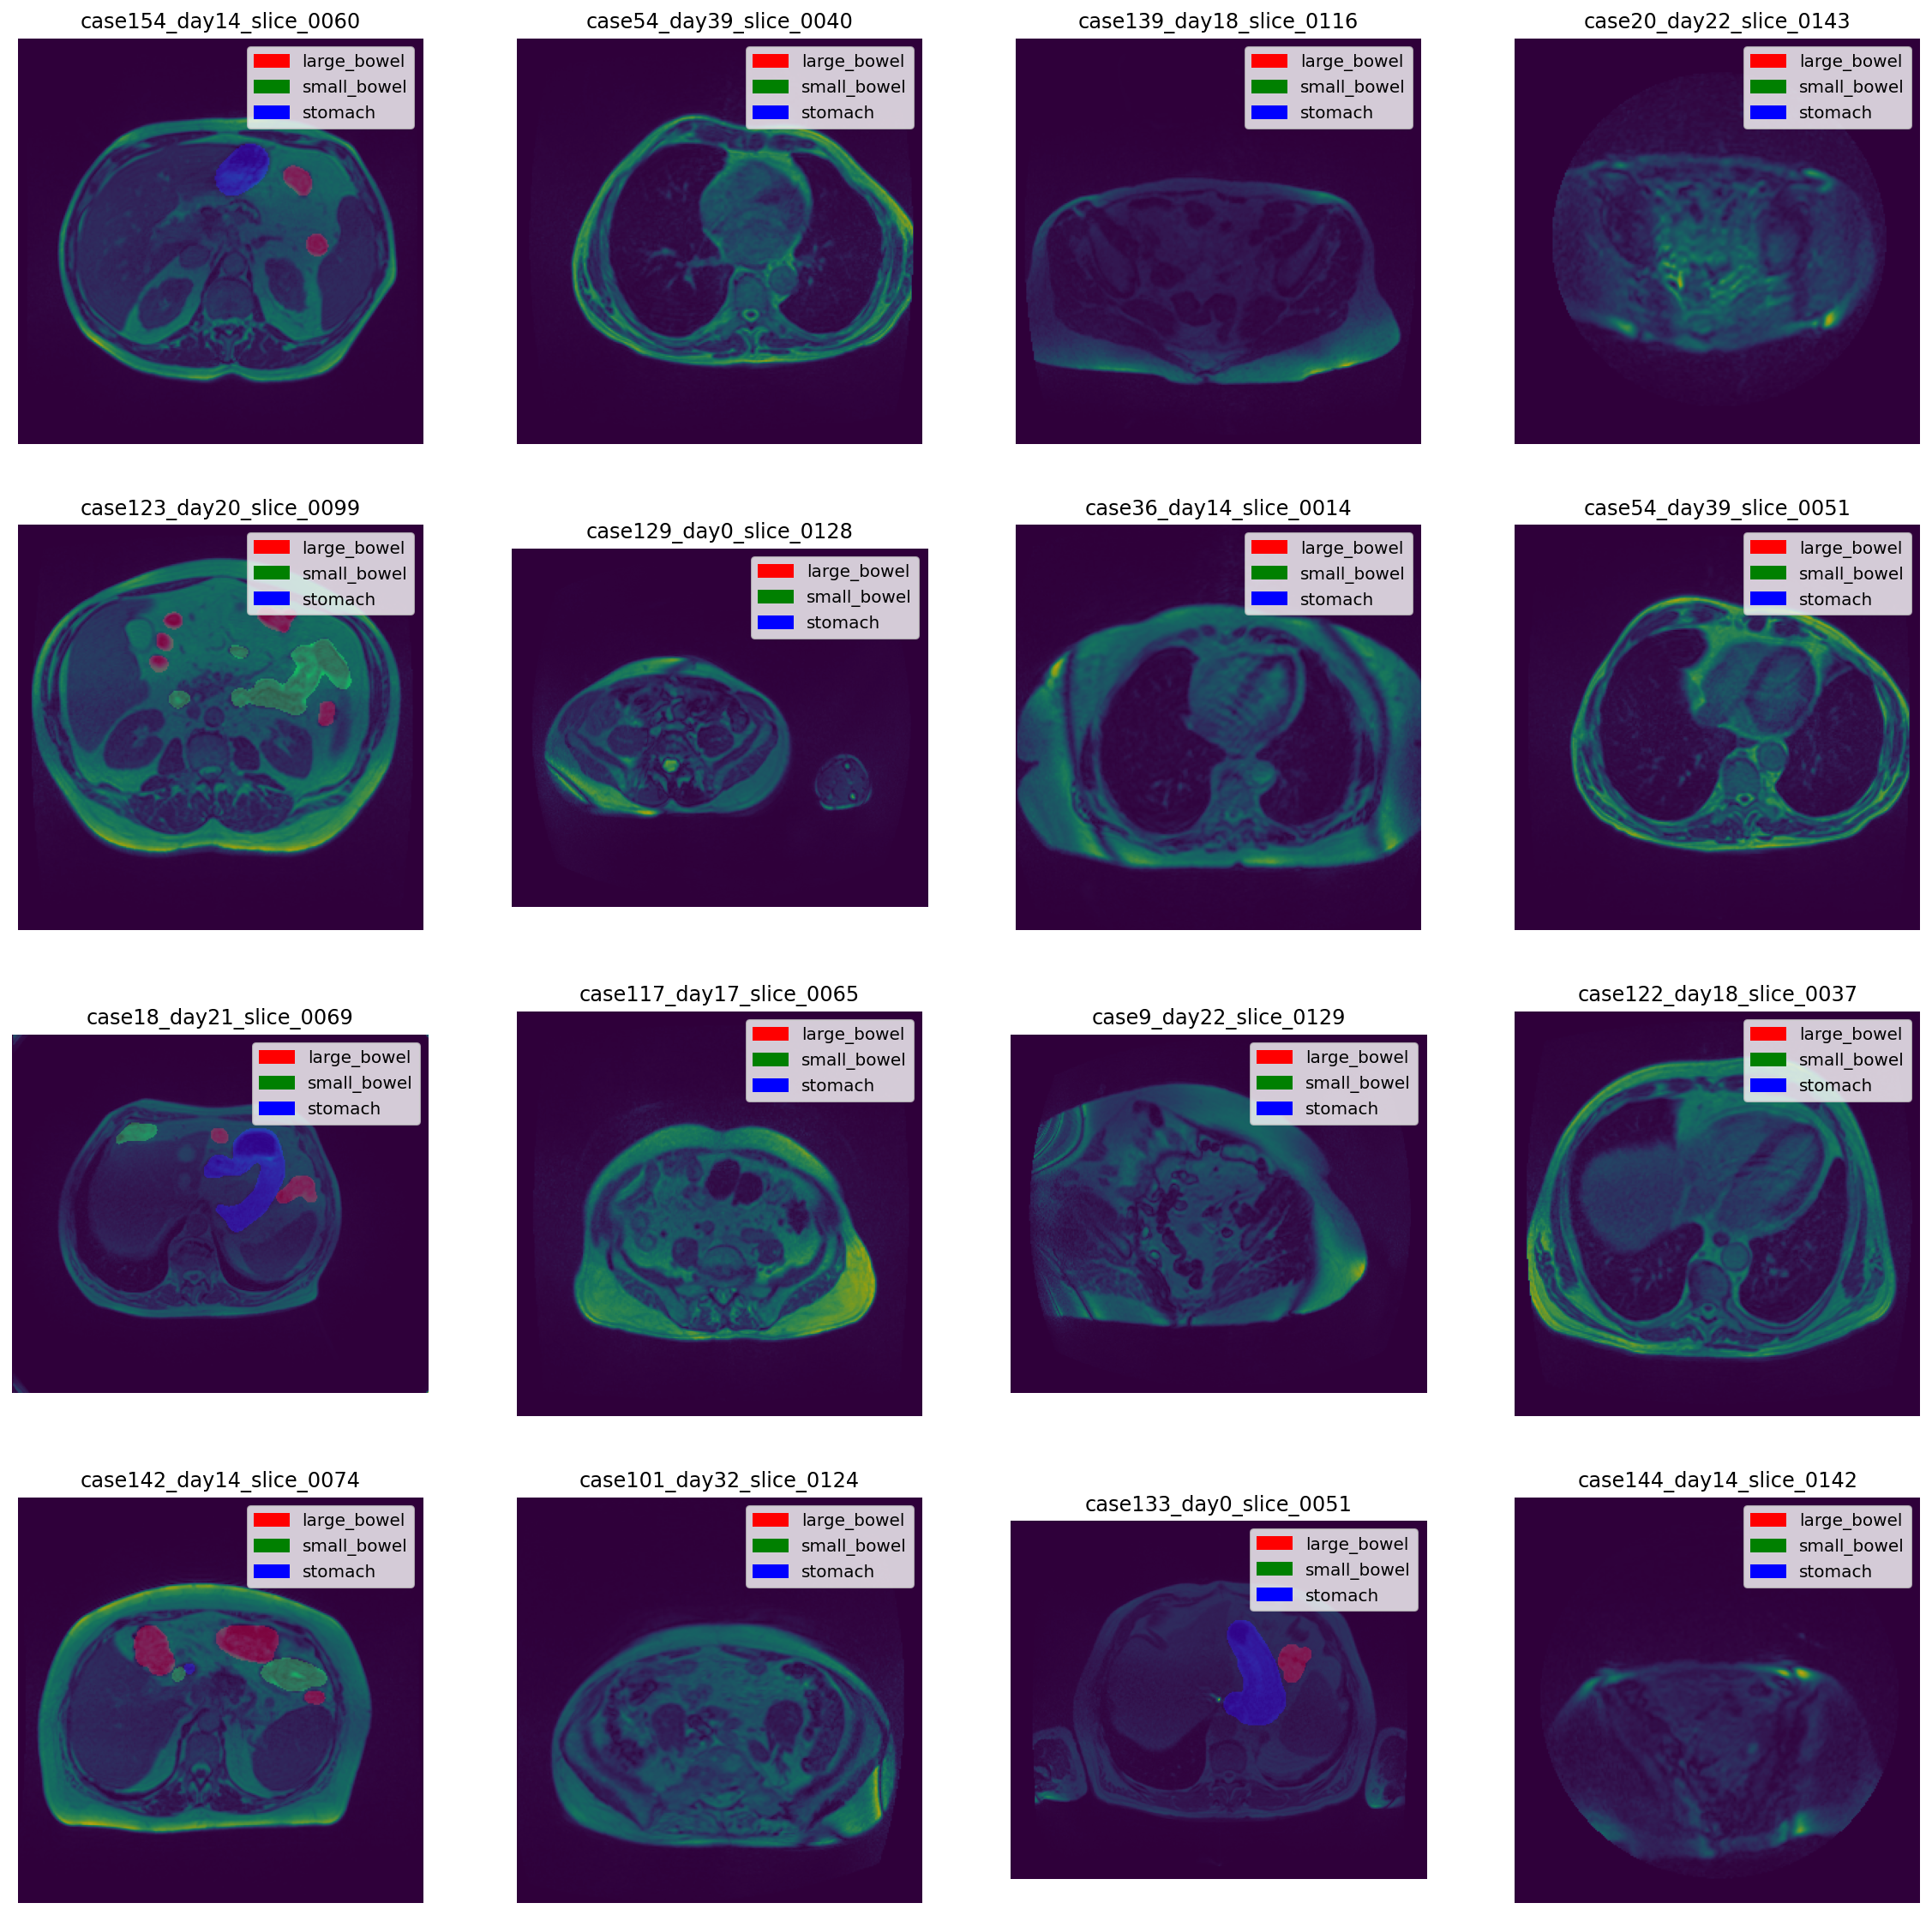

In [83]:
plt.figure(figsize=(20, 20))
for i in range(16):
    colors = ["red", "green", "blue"]
    ix = np.random.randint(df.shape[0])
    img = read_img(
        img_path=df.loc[ix, "img_path"],
    )
    mask = np.zeros([img.shape[0], img.shape[1], 3])
    for c in range(3):
        rle = df.loc[ix, labels[c]]
        if rle == rle:
            mask[:, :, c] = rle_decode(rle, img.shape[:2])
    plt.subplot(4, 4, i + 1)
    plt.title(df.loc[ix, "id"])
    plt.imshow(img)
    plt.imshow(mask, alpha=0.3)
    handles = [Rectangle((0, 0), 1, 1, color=c) for c in colors]
    plt.legend(handles, labels)
    plt.axis("off")
plt.show();

## mask statistics

For this purpose it is more convenient to use long-format dataframe

In [89]:
df_long = (
    df[["id", "large_bowel", "small_bowel", "stomach"]]
    .melt(
        id_vars="id",
        value_vars=["large_bowel", "small_bowel", "stomach"],
        var_name="class",
        value_name="segmentation",
    )
    .merge(df[["id", "real_height", "real_width"]])
)

In [116]:
ids = df_long.id.unique().tolist()
for idx in tqdm(ids):
    new_df = df_long[df_long["id"] == idx]
    for n, i in enumerate(new_df.index):
        rle = new_df.loc[i, "segmentation"]
        img_shape = new_df[["real_height", "real_width"]].astype('int').values[0]
        mask = np.zeros([img_shape[0], img_shape[1], 3])
        if rle == rle:
            rle_mask = np.array(rle.split(), dtype="int")
            lenghts = rle_mask[1::2]
            single_mask = rle_decode(rle, img_shape)
            mask[:,:,n] = single_mask
            label_objects, nb_labels = ndi.label(single_mask)
            sizes = np.bincount(label_objects.ravel())[1:]
            df_long.loc[i, "min_mask_size"] = np.min(sizes)
            df_long.loc[i, "max_mask_size"] = np.max(sizes)
            df_long.loc[i, "min_mask_lenght"] = np.min(lenghts)
        mask = np.sum(mask, -1)
        if (mask>1).sum():
            df_long.loc[i, "intersection"] = (mask>1).sum()


100% 38496/38496 [14:04<00:00, 45.56it/s]


In [114]:
img_shape

array([310, 360])

In [113]:
new_df

id        class  \
1923  case102_day0_slice_0066  large_bowel   
1924  case102_day0_slice_0066  small_bowel   
1925  case102_day0_slice_0066      stomach   

                                           segmentation  real_height  \
1923                                                NaN        310.0   
1924                                                NaN        310.0   
1925  45596 6 45954 9 46313 11 46671 13 47031 13 473...        310.0   

      real_width  min_mask_size  max_mask_size  min_mask_lenght  intersection  
1923       360.0            NaN            NaN              NaN           NaN  
1924       360.0            NaN            NaN              NaN           NaN  
1925       360.0            NaN            NaN              NaN           NaN

In [118]:
df_long[["min_mask_size", "max_mask_size", "min_mask_lenght", "intersection"]].describe()

min_mask_size  max_mask_size  min_mask_lenght  intersection
count   33913.000000   33913.000000     33913.000000     92.000000
mean      573.991508    1121.244950         3.294312     19.086957
std       766.535873     867.661874         2.246012     26.375835
min         1.000000      11.000000         1.000000      1.000000
25%       142.000000     523.000000         2.000000      6.750000
50%       285.000000     894.000000         3.000000     14.000000
75%       652.000000    1465.000000         4.000000     23.250000
max      6964.000000    6964.000000        22.000000    227.000000

In [120]:
df_long.groupby("class")[
    ["min_mask_size", "max_mask_size", "min_mask_lenght"]
].describe(percentiles=[0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75]).T

class                   large_bowel   small_bowel      stomach
min_mask_size   count  14085.000000  11201.000000  8627.000000
                mean     381.291161    318.472993  1220.363046
                std      407.257026    548.410056  1041.836947
                min        1.000000      1.000000     1.000000
                1%        40.000000     31.000000    76.000000
                5%        70.000000     51.000000   151.000000
                10%       94.000000     67.000000   235.000000
                15%      115.000000     79.000000   327.900000
                25%      155.000000     99.000000   477.000000
                50%      270.000000    156.000000   877.000000
                75%      457.000000    285.000000  1684.000000
                max     6964.000000   6264.000000  6917.000000
max_mask_size   count  14085.000000  11201.000000  8627.000000
                mean     985.574796   1180.832247  1265.382752
                std      725.637715    871.595422  1028.665443
                min       11.000000     29.000000    12.000000
                1%        93.000000     84.000000    89.260000
                5%       196.000000    173.000000   193.000000
                10%      280.000000    274.000000   306.600000
                15%      357.000000    370.000000   384.000000
                25%      499.000000    559.000000   538.000000
                50%      813.000000    996.000000   935.000000
                75%     1271.000000   1549.000000  1726.000000
                max     6964.000000   6264.000000  6917.000000
min_mask_lenght count  14085.000000  11201.000000  8627.000000
                mean       2.850834      2.434515     5.134693
                std        1.591291      1.509500     2.840890
                min        1.000000      1.000000     1.000000
                1%         1.000000      1.000000     1.000000
                5%         1.000000      1.000000     1.000000
                10%        1.000000      1.000000     2.000000
                15%        1.000000      1.000000     2.000000
                25%        2.000000      1.000000     3.000000
                50%        3.000000      2.000000     5.000000
                75%        4.000000      3.000000     7.000000
                max       17.000000     21.000000    22.000000

In [61]:
for i in df[df["min_mask_size"] == 1].index[1:2]:
    img, _, _ = read_img(
        img_path=df.loc[i, "img_path"],
        to_rgb=False,
        norm=True,
        uint8=False,
        img_size=None,
    )
    rle = df.loc[i, "segmentation"]
    if rle == rle:
        rle_mask = np.array(rle.split(), dtype="int")
        lenghts = rle_mask[1::2]
        single_mask = rle_decode(rle, img.shape[:2])
        label_objects, nb_labels = ndi.label(single_mask)
        sizes = np.bincount(label_objects.ravel())[1:]

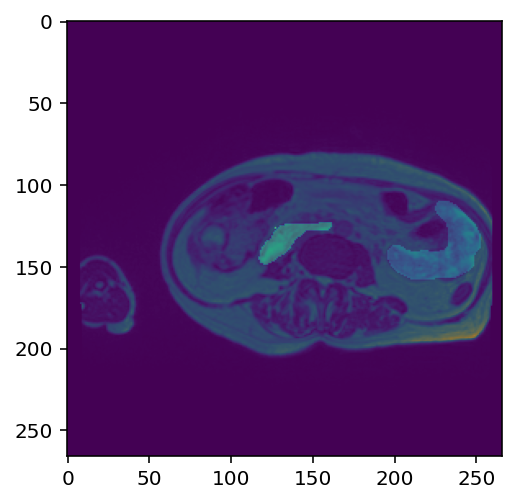

In [62]:
plt.imshow(img)
plt.imshow(label_objects, alpha=0.5)

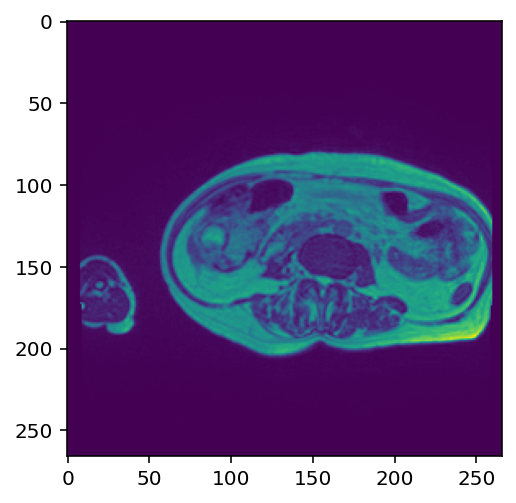

In [63]:
plt.imshow(img)

In [64]:
sizes

array([1359,  446,    1])

In [ ]:
df = df.pivot(index="id", columns="class", values="segmentation").reset_index()
df = df.fillna("")
for ix in df.index[1:-1]:
    for organ in "large_bowel", "small_bowel", "stomach":
        if df.loc[ix, organ] == "":
            if df.loc[ix - 1, organ] != "" and df.loc[ix + 1, organ] != "":
                print(ix)